In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder

In [58]:
data = pd.read_csv('DBS.csv', sep=';')
test = pd.read_csv('DBS_2020.csv', sep=';')

In [59]:
data['result_grade'].value_counts()

C     70
FX    51
D     45
B     45
A     28
E     22
Name: result_grade, dtype: int64

In [60]:
drop_list = ['result_grade', 'year', 'acad_year']
df = data.drop(drop_list, axis=1)
test1 = test.drop(drop_list, axis=1).copy()

In [61]:
df['graduate'].value_counts()

1    210
0     51
Name: graduate, dtype: int64

In [62]:
df.isna().sum()

access           0
tests            0
tests_grade      0
exam             0
project          0
project_grade    0
assignments      0
result_points    0
graduate         0
dtype: int64

In [63]:
test.isna().sum()

access           0
tests            0
tests_grade      0
exam             0
project          0
project_grade    0
assignments      0
result_points    0
result_grade     0
graduate         0
year             0
acad_year        0
dtype: int64

In [64]:
str_cols = df.select_dtypes(object).columns

for col in str_cols:
    print(col, np.unique(df[col]))

tests_grade ['0' 'A' 'B' 'C' 'D' 'E' 'FX']
project_grade ['0' 'A' 'B' 'C' 'D' 'E' 'FX']


In [65]:
for col in str_cols:
    print(col, np.unique(test1[col]))

tests_grade ['A' 'B' 'C' 'D' 'E' 'FX']
project_grade ['A' 'B' 'C' 'D' 'E' 'FX']


In [66]:
for col in str_cols:
    df[col] = df[col].apply(lambda x: 'FX' if x=='0' else x)

In [67]:
for col in str_cols:
    print(col, np.unique(df[col]))

tests_grade ['A' 'B' 'C' 'D' 'E' 'FX']
project_grade ['A' 'B' 'C' 'D' 'E' 'FX']


In [68]:
np.unique(df[col]).tolist()[::-1]

['FX', 'E', 'D', 'C', 'B', 'A']

In [69]:
for col in str_cols:
    en = OrdinalEncoder(categories=[np.unique(df[col]).tolist()[::-1]],  handle_unknown='use_encoded_value', unknown_value=-1)
    df[col] = en.fit_transform(df[col].values.reshape(-1,1))
    test1[col] = en.transform(test1[col].values.reshape(-1,1))

In [168]:
drop_feats = ['graduate', ] #'result_points'
X_train, y_train = df.drop(drop_feats, axis=1), df['graduate']
X_test, y_test = test1.drop(drop_feats, axis=1), test1['graduate']

In [169]:
pf = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)
pf.fit(X_train)

PolynomialFeatures(include_bias=False, interaction_only=True)

In [170]:
X_train = pf.transform(X_train)
X_test = pf.transform(X_test)

In [171]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [172]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [173]:
model_ld = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
model_ld.fit(X_train, y_train)

pred_ld = model_ld.predict(X_test)

print(model_ld.score(X_test, y_test))
print(f1_score(y_test, pred_ld))

0.9666666666666667
0.9777777777777777


In [174]:
model_lr = LogisticRegression(solver='lbfgs', C=1., random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

pred_lr = model_lr.predict(X_test)

print(model_lr.score(X_test, y_test))
print(f1_score(y_test, pred_lr))

0.9666666666666667
0.9777777777777777


In [175]:
rfecv = RFECV(estimator=model_lr, cv=10, scoring='f1')

rfecv.fit(X_train, y_train)

rfecv.ranking_

array([ 1,  1,  1,  1,  1,  1, 10,  7,  9,  1,  3,  1,  1,  1,  1,  1,  1,
        6,  1,  1,  1,  4,  1, 11,  1,  5,  8,  1,  1,  1,  1,  1,  2,  1,
        1,  1])

In [176]:
model_lr = LogisticRegression(solver='lbfgs', C=1., random_state=42)
model_lr.fit(rfecv.transform(X_train), y_train)

pred_lr = model_lr.predict(rfecv.transform(X_test))

print(model_lr.score(rfecv.transform(X_test), y_test))
print(f1_score(y_test, pred_lr))

0.9666666666666667
0.9777777777777777


<BarContainer object of 8 artists>

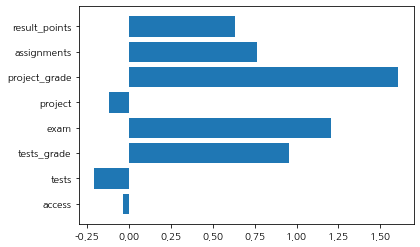

In [148]:
plt.barh( df.drop(drop_feats, axis=1).columns, model_lr.coef_[0])

In [149]:
pd.DataFrame(confusion_matrix(y_test, pred_lr, labels=[1, 0]), index=['True 1', 'Trud 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,45,1
Trud 0,2,12


In [177]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

print(model_rf.score(X_test, y_test))
print(f1_score(y_test, pred_rf))
print(roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

0.95
0.967032967032967
0.9953416149068324


In [178]:
rfecv = RFECV(estimator=model_rf, scoring='f1')

rfecv.fit(X_train, y_train)

RFECV(estimator=RandomForestClassifier(random_state=42), scoring='f1')

In [179]:
rfecv.ranking_

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1,
       7, 6, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [180]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(rfecv.transform(X_train), y_train)

pred_rf = model_rf.predict(rfecv.transform(X_test))

print(model_rf.score(rfecv.transform(X_test), y_test))
print(f1_score(y_test, pred_rf))
print(roc_auc_score(y_test, model_rf.predict_proba(rfecv.transform(X_test))[:, 1]))

0.95
0.967032967032967
0.9968944099378882


<BarContainer object of 8 artists>

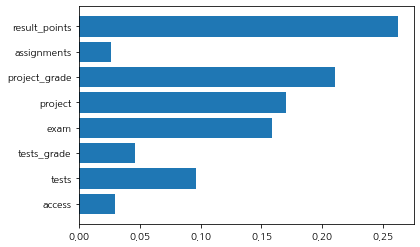

In [131]:
plt.barh( df.drop(drop_feats, axis=1).columns, model_rf.feature_importances_)

In [135]:
pd.DataFrame(confusion_matrix(y_test, pred_rf, labels=[1, 0]), index=['True 1', 'Trud 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,45,1
Trud 0,2,12
